<Body>   
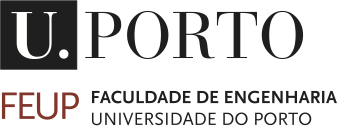   
<h1> <b>Perception and Mapping </b> </h1>
<p><b>Andry Maykol Pinto </b> (amgp@fe.up.pt)</p>
<p>Department of Electrical and Computer Engineering</p>
</Body>  
FEUP

---

# Introducing 3D data processing
This lecture is inspired on the [Open3D](http://www.open3d.org/docs/release/index.html) documentation and will explore some techniques for 3D data processing:

* Transformations
* Filtering and outlier treatment
* Point cloud compression and search
* Clustering and segmentation

________

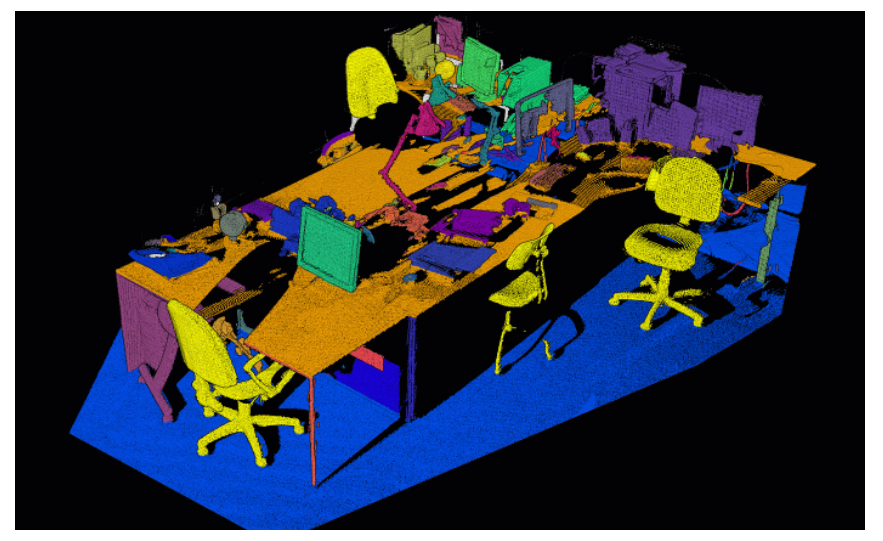

Figure 1 - Clustering point clouds. credits: F. Poux

In [37]:
# Install Open3D library
!pip install open3d

In [38]:
# Import libraries
import numpy as np
import open3d as o3d

# Visualization
import plotly.graph_objects as go  # plotly to visualize since COLAB does not allow to use O3D functions
import matplotlib.pyplot as plt # or, Matplotlib
from mpl_toolkits import mplot3d

In [39]:
# Visualize point cloud as a scatter plot using matplotlib (as an image!)
def plot_pointcloud_matplotlib_singleview (pt, title_ = ' ', view_ =(-90, 90, 0)):
  colors = None
  if pt.has_colors():
      colors = np.asarray(pt.colors)
  elif pt.has_normals():
      colors = (0.5, 0.5, 0.5) + np.asarray(pt.normals) * 0.5
  else:
      pt.paint_uniform_color((1.0, 0.0, 0.0))
      colors = np.asarray(pt.colors)

  points = np.asarray(pt.points)
  # Single View
  ax = plt.axes(projection='3d')
  ax.view_init(view_[0], view_[1], view_[2])
  ax.axis("on")
  ax.scatter(points[:,0], points[:,1], points[:,2], c=colors)
  ax.set_xlabel('X axis')
  ax.set_ylabel('Y axis')
  ax.set_zlabel('Z axis')

  plt.title(title_)
  plt.show()

#Plotly
def draw_geometries(geometries):
    graph_objects = []

    for geometry in geometries:
        geometry_type = geometry.get_geometry_type()

        if geometry_type == o3d.geometry.Geometry.Type.PointCloud:
            points = np.asarray(geometry.points)
            colors = None
            if geometry.has_colors():
                colors = np.asarray(geometry.colors)
            elif geometry.has_normals():
                colors = (0.5, 0.5, 0.5) + np.asarray(geometry.normals) * 0.5
                geometry.colors = o3d.utility.Vector3dVector(colors)
            else:
                geometry.paint_uniform_color((1.0, 0.0, 0.0))
                colors = np.asarray(geometry.colors)

            scatter_3d = go.Scatter3d(x=points[:,0], y=points[:,1], z=points[:,2], mode='markers', marker=dict(size=2, color=colors))
            graph_objects.append(scatter_3d)

        if geometry_type == o3d.geometry.Geometry.Type.TriangleMesh:
            triangles = np.asarray(geometry.triangles)
            vertices = np.asarray(geometry.vertices)
            colors = None
            if geometry.has_triangle_normals():
                colors = (0.5, 0.5, 0.5) + np.asarray(geometry.triangle_normals) * 0.5
                colors = tuple(map(tuple, colors))
            else:
                colors = (1.0, 0.0, 0.0)

            mesh_3d = go.Mesh3d(x=vertices[:,0], y=vertices[:,1], z=vertices[:,2], i=triangles[:,0], j=triangles[:,1], k=triangles[:,2], facecolor=colors, opacity=0.50)
            graph_objects.append(mesh_3d)

        if geometry_type == o3d.geometry.Geometry.Type.VoxelGrid:
            bounds     = geometry.get_max_bound()-geometry.get_min_bound()

            voxels     = geometry.get_voxels()   # Returns List of Voxel
            vox_mesh   = o3d.geometry.TriangleMesh()

            for v in voxels:
                cube = o3d.geometry.TriangleMesh.create_box(width=1, height=1, depth=1)
                cube.paint_uniform_color(v.color)
                cube.translate(v.grid_index, relative=False)
                vox_mesh += cube

            vox_mesh.translate([0.5,0.5,0.5], relative=True)

            vox_mesh.merge_close_vertices(0.0000001)
            # T=np.array([[1, 0, 0, 0],[0, 0, 1, 0],[0, -1, 0, 0],[0, 0, 0, 1]])
            vox_mesh.translate(geometry.origin, relative=True)

            # Now is like a TriangleMesh
            triangles = np.asarray(vox_mesh.triangles)
            vertices = np.asarray(vox_mesh.vertices)
            colors = None
            if vox_mesh.has_triangle_normals():
                colors = (0.5, 0.5, 0.5) + np.asarray(vox_mesh.triangle_normals) * 0.5
                colors = tuple(map(tuple, colors))
            else:
                vox_mesh.compute_vertex_normals()
                colors = (0.5, 0.5, 0.5) + np.asarray(vox_mesh.triangle_normals) * 0.5
                colors = tuple(map(tuple, colors))                                        # or colors = (0, 0, 0)

            mesh_3d = go.Mesh3d(x=vertices[:,0], y=vertices[:,1], z=vertices[:,2], i=triangles[:,0], j=triangles[:,1], k=triangles[:,2], facecolor=colors, opacity=0.50)
            graph_objects.append(mesh_3d)

    fig = go.Figure(
        data=graph_objects,
        layout=dict(
            scene=dict(
                xaxis=dict(visible=False),
                yaxis=dict(visible=False),
                zaxis=dict(visible=False)
            )
        )
    )
    fig.show()

In [40]:
o3d.visualization.draw_geometries = draw_geometries # replacing the function of Open3D

# Transformation

Transforming point clouds is a fundamental operation for various applications like registration, alignment, and data preprocessing. In Open3D, it is possible to perform transformations such as translation, rotation, and scaling in order to manipulate point cloud data.

In [41]:
# Download a PLY file
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=14w0J7SjyXSynE6a6WsROtR1uKHddKtGT' -O fragments.zip

--2025-01-11 10:31:40--  https://docs.google.com/uc?export=download&id=14w0J7SjyXSynE6a6WsROtR1uKHddKtGT
Resolving docs.google.com (docs.google.com)... 172.217.15.238, 2607:f8b0:4025:802::200e
Connecting to docs.google.com (docs.google.com)|172.217.15.238|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=14w0J7SjyXSynE6a6WsROtR1uKHddKtGT&export=download [following]
--2025-01-11 10:31:40--  https://drive.usercontent.google.com/download?id=14w0J7SjyXSynE6a6WsROtR1uKHddKtGT&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.250.65.97, 2607:f8b0:4025:804::2001
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.250.65.97|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6195091 (5.9M) [application/octet-stream]
Saving to: ‘fragments.zip’

fragments.zip       100%[===================>]   5.91M  39.0MB/s    in 0.2s    



In [42]:
# Extract point clouds from ZIP file.
import zipfile
import os

with zipfile.ZipFile("fragments.zip", mode="r") as archive:
  for file in archive.namelist():
    archive.extract(file, "pointclouds_dir/")

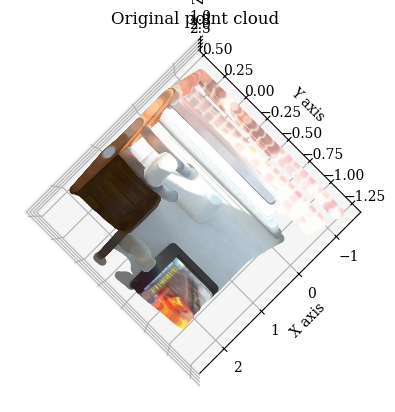

In [43]:
# Load a PLY file as a point cloud
pt_cloud_original = o3d.io.read_point_cloud("pointclouds_dir/fragment_000.ply", format='ply')
if pt_cloud_original.is_empty():
  exit()

# Visualize the point cloud
#o3d.visualization.draw_geometries([pt_cloud])
plot_pointcloud_matplotlib_singleview(pt_cloud_original, 'Original point cloud', (-90, 90, 45))

## Scale

Scaling will resize the point cloud along the X, Y, and Z axes. You can use the scale method to perform scaling, $vs = s⋅v$. The `scale` method also has a second argument `center` that is set to `True` by default. The object is not centered prior to scaling when `center = False`, which means that the center of the object will move due to the scaling operation.

Original Center is located at [ 0.32354878 -0.07202292  1.78881698]
New Center is located at [ 0.32354878 -0.07202292  1.78881698]


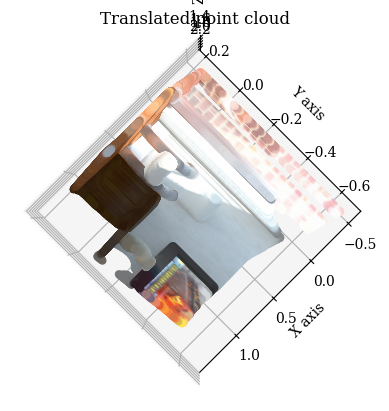

In [44]:
import copy

# Example of scalling a point cloud
#Copy pt
pt_cloud = copy.deepcopy(pt_cloud_original) # https://docs.python.org/3/library/copy.html

# Scalling
pt_cloud.scale(0.5, center=pt_cloud.get_center())

print('Original Center is located at', pt_cloud_original.get_center())
print('New Center is located at', pt_cloud.get_center())

# Visualize the point cloud
#o3d.visualization.draw_geometries([pcd])
plot_pointcloud_matplotlib_singleview(pt_cloud, 'Translated point cloud', (-90, 90, 45))

## Translation

The `translate` method takes a single 3D vector $t$ as input and translates all points/vertices of the geometry by this vector, $vt=v+t$. The code below shows how the point cloud or mesh is translated by 3.0 meters in the x-directon and -2.0 meters in the y-direction.

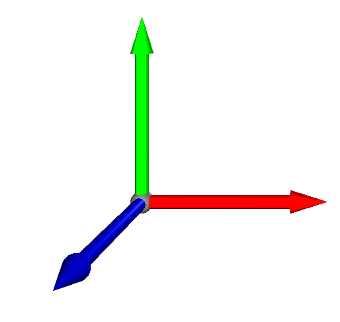
Figure 2 - Axes RGB in 3D

Original Center is located at [ 0.32354878 -0.07202292  1.78881698]
New Center is located at [ 3.32354878 -2.07202292  1.78881698]


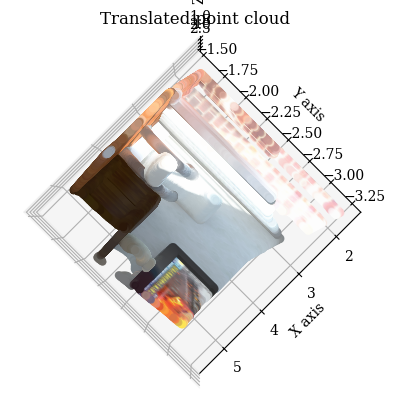

In [45]:
# Define the translation vector
translation = [3.0, -2.0, 0.0]

#Copy pt
pt_cloud = copy.deepcopy(pt_cloud_original) # https://docs.python.org/3/library/copy.html

# Apply translation to the point cloud
pt_cloud.translate(translation)

print('Original Center is located at', pt_cloud_original.get_center())
print('New Center is located at', pt_cloud.get_center())

# Visualize the point cloud
#o3d.visualization.draw_geometries([pcd])
plot_pointcloud_matplotlib_singleview(pt_cloud, 'Translated point cloud', (-90, 90, 45))

The method takes a second argument `relative` that is by default set to `True`. If set to `False`, the center of the geometry (is the mean - check method `get_center`) is translated directly to the position specified in the first argument.

Original Center is located at [ 0.32354878 -0.07202292  1.78881698]
New Center is located at [ 3.00000000e+00 -2.00000000e+00  3.27514861e-14]


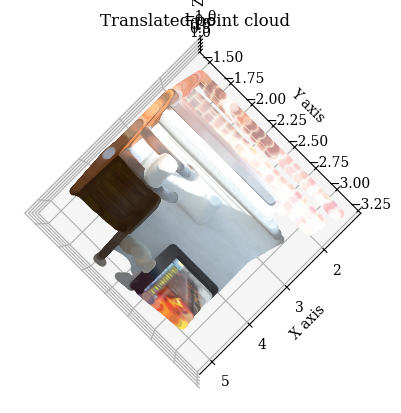

In [46]:
# Copy pt
pt_cloud = copy.deepcopy(pt_cloud_original) # https://docs.python.org/3/library/copy.html

# Apply translation to the point cloud
pt_cloud.translate(translation, relative = False)

print('Original Center is located at', pt_cloud_original.get_center())
print('New Center is located at', pt_cloud.get_center())

# Visualize the point cloud
#o3d.visualization.draw_geometries([pt_cloud])
plot_pointcloud_matplotlib_singleview(pt_cloud, 'Translated point cloud', (-90, 90, 45))

## Rotation
The method `rotate` performs rotations to geometry types of Open3D, where the first argument is a rotation matrix $R$. Open3D provides many functions to convert from different parametrizations to rotation matrices:

* From Euler angles with `get_rotation_matrix_from_xyz`, where xyz can also be of the form $yzx$, $zxy$, $xzy$, $zyx$, and $yxz$

* From Axis-angle representation with `get_rotation_matrix_from_axis_angle`

* From Quaternions with `get_rotation_matrix_from_quaternion`

The method `rotate` has a second argument `center` that is by default set to `True` which indicates that:
1. the object is first centered prior to applying the rotation
2. the object is then moved back to its previous center.

A rotation around the coordinate center is aplied to the geometry when `center = False`.

Original Center is located at [ 0.32354878 -0.07202292  1.78881698]
New Center is located at [ 0.32354878 -0.07202292  1.78881698]


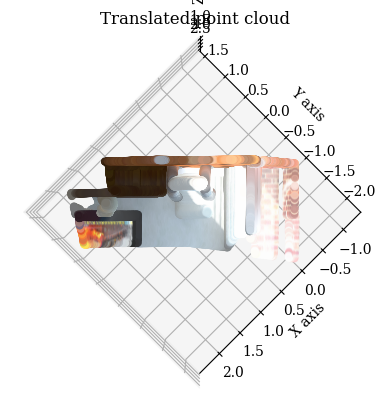

In [47]:
# Example of rotating a point cloud around the Z-axis by 45º
# Copy pt
pt_cloud = copy.deepcopy(pt_cloud_original) # https://docs.python.org/3/library/copy.html

# Define the rotation angle (in radians)
angle_rad = np.pi / 4.0  # 45 degrees

# Prepare a rotation matrix
R = np.array([[np.cos(angle_rad), -np.sin(angle_rad), 0],
              [np.sin(angle_rad), np.cos(angle_rad), 0],
              [0, 0, 1]])

# Apply rotation to the point cloud
pt_cloud.rotate(R)

print('Original Center is located at', pt_cloud_original.get_center())
print('New Center is located at', pt_cloud.get_center())

# Visualize the point cloud
#o3d.visualization.draw_geometries([pcd])
plot_pointcloud_matplotlib_singleview(pt_cloud, 'Translated point cloud', (-90, 90, 45))

Original Center is located at [ 0.32354878 -0.07202292  1.78881698]
New Center is located at [ 0.32354878 -0.07202292  1.78881698]


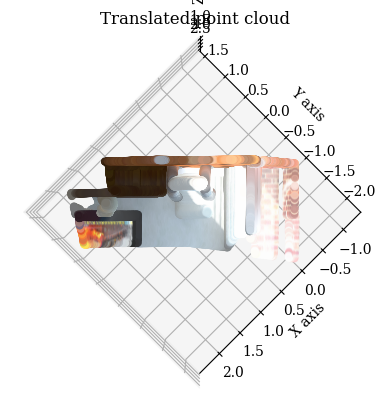

In [48]:
# Example of rotating a point cloud around the Z-axis by 45º (using the method "get_rotation_matrix_from_xyz")
# Copy pt
pt_cloud = copy.deepcopy(pt_cloud_original) # https://docs.python.org/3/library/copy.html

# Prepare rotation matrix
R = pt_cloud.get_rotation_matrix_from_xyz((0, 0, np.pi / 4))

# Apply translation to the point cloud
pt_cloud.rotate(R)

print('Original Center is located at', pt_cloud_original.get_center())
print('New Center is located at', pt_cloud.get_center())

# Visualize the point cloud
#o3d.visualization.draw_geometries([pcd])
plot_pointcloud_matplotlib_singleview(pt_cloud, 'Translated point cloud', (-90, 90, 45))

Original Center is located at [ 0.32354878 -0.07202292  1.78881698]
New Center is located at [ 0.32354878 -0.07202292  1.78881698]


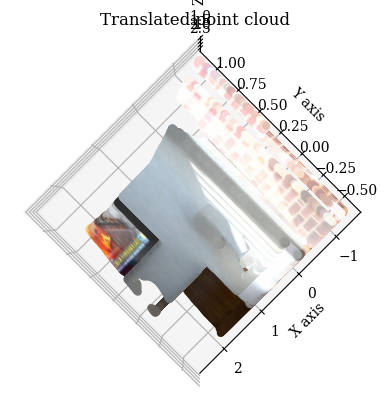

In [49]:
# Example of rotating a point cloud around the X-axis by 180 (using the method "get_rotation_matrix_from_xyz")
# Copy pt
pt_cloud = copy.deepcopy(pt_cloud_original) # https://docs.python.org/3/library/copy.html

# Prepare rotation matrix
R = pt_cloud.get_rotation_matrix_from_xyz((np.pi, 0, 0))

# Apply translation to the point cloud
pt_cloud.rotate(R)

print('Original Center is located at', pt_cloud_original.get_center())
print('New Center is located at', pt_cloud.get_center())

# Visualize the point cloud
#o3d.visualization.draw_geometries([pcd])
plot_pointcloud_matplotlib_singleview(pt_cloud, 'Translated point cloud', (-90, 90, 45))

## General Transformation
It is possible to define a homogeneous transformation matrix to apply a rotation and translation using the method `transform`. The homogeneous transformation matrix is described as one matrix $[R|T]$, where $R$ is the rotation matrix and $T$ is the translation matrix. A $[0,0,0,1]$ is added to the 4th row to complete this 4x4 matrix.

Original Center is located at [ 0.32354878 -0.07202292  1.78881698]
New Center is located at [ 1.32354878  1.57202292 -1.78881698]


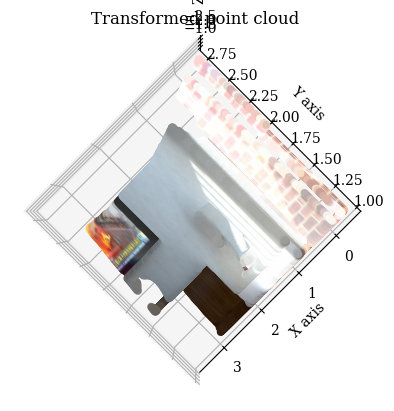

In [50]:
# Example of rotating a point cloud around the X-axis by 180 (using the method "get_rotation_matrix_from_xyz")
# Copy pt
pt_cloud = copy.deepcopy(pt_cloud_original) # https://docs.python.org/3/library/copy.html

# Prepare rotation matrix
R = pt_cloud.get_rotation_matrix_from_xyz((np.pi, 0, 0))

# Prepare Transformation matrix
H         = np.eye(4)
H[:3, :3] = R
H[0, 3]   = 1
H[1, 3]   = 1.5

# Apply translation to the point cloud
pt_cloud.transform(H)

print('Original Center is located at', pt_cloud_original.get_center())
print('New Center is located at', pt_cloud.get_center())

# Visualize the point cloud
#o3d.visualization.draw_geometries([pcd])
plot_pointcloud_matplotlib_singleview(pt_cloud, 'Transformed point cloud', (-90, 90, 45))


# Filtering and outlier removal

Filtering point clouds is a common operation in 3D data processing to remove noise and unwanted points, thereby improving data quality and reducing computational complexity for subsequent tasks. Open3D provides various methods for point cloud filtering namely,
* Statistical Outlier Removal.
* Radius Outlier Removal.
* Pass-Through Filtering.

It is possible to setup the attributes of the geometry that will be filtered using the [FilterScope](http://www.open3d.org/docs/release/python_api/open3d.geometry.FilterScope.html). For rendering purposes, Open3D has a method called `hidden_point_removal`, see [documentation](http://www.open3d.org/docs/latest/tutorial/Basic/pointcloud.html#Hidden-point-removal) which avoids points from the background to leak into the foreground because they are not occluded by other points.

## Pass-Through Filtering
Pass-through filtering allows you to define a range in each dimension and keep only the points within that range. It's useful for isolating a specific region of interest.
Cropping a point cloud in Open3D involves defining a region of interest (ROI) and keeping only the points that fall within that region. You can use the `crop` method, which allows you to specify an axis-aligned bounding box or a custom geometry as the ROI.



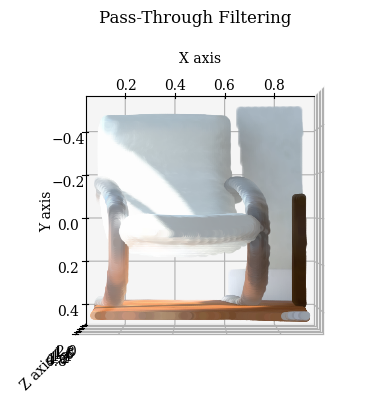

In [51]:
# Example of cropping a point cloud
# Copy pt
pt_cloud = copy.deepcopy(pt_cloud_original) # https://docs.python.org/3/library/copy.html

# Define the range for x, y, and z dimensions
x_range = [0.1, 0.9]
y_range = [-0.5, 0.5]
z_range = [0.0, 2.0]

# Create an axis-aligned bounding box
roi = o3d.geometry.AxisAlignedBoundingBox(min_bound=[x_range[0], y_range[0], z_range[0]],
                                          max_bound=[x_range[1], y_range[1], z_range[1]])
# Crop the point cloud
pt_cloud_cropped = pt_cloud.crop(roi)

# Visualize the original and cropped point clouds
#o3d.visualization.draw_geometries([pt_cloud_cropped])
plot_pointcloud_matplotlib_singleview(pt_cloud_cropped, 'Pass-Through Filtering', (-90, 90, 180))

## Statistical outlier removal

Statistical outlier removal is a point cloud filtering technique that identifies and removes points considered as outliers based on statistical analysis of point neighborhoods. This method helps to clean noisy point cloud data by removing points that deviate significantly from the local point density.
The method `remove_statistical_outlier`` performs statistical outlier removal in Open3D, see [documentation](http://www.open3d.org/docs/latest/tutorial/Advanced/pointcloud_outlier_removal.html).

This method returns two outputs: a boolean mask indicating inlier points and the indices of inlier points. Points marked as outliers are removed from the original point cloud.

In [52]:
# Download a PLY file
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1DW_Gq3avj3lb8ZmqEGdahA2hWhne7P9F' -O durius.ply

# Load a PLY file as a point cloud
pt_cloud_durius = o3d.io.read_point_cloud("durius.ply")
if pt_cloud_durius.is_empty():
  exit()

--2025-01-11 10:33:38--  https://docs.google.com/uc?export=download&id=1DW_Gq3avj3lb8ZmqEGdahA2hWhne7P9F
Resolving docs.google.com (docs.google.com)... 172.217.15.238, 2607:f8b0:4025:802::200e
Connecting to docs.google.com (docs.google.com)|172.217.15.238|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1DW_Gq3avj3lb8ZmqEGdahA2hWhne7P9F&export=download [following]
--2025-01-11 10:33:38--  https://drive.usercontent.google.com/download?id=1DW_Gq3avj3lb8ZmqEGdahA2hWhne7P9F&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.250.65.97, 2607:f8b0:4025:804::2001
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.250.65.97|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 36061 (35K) [application/octet-stream]
Saving to: ‘durius.ply’

durius.ply          100%[===================>]  35.22K  --.-KB/s    in 0.004s  

2025-0

In [53]:
def display_inlier_outlier(cloud, ind):
    inlier_cloud = cloud.select_by_index(ind)
    outlier_cloud = cloud.select_by_index(ind, invert=True)

    print("Showing outliers (red) and inliers (gray): ")
    outlier_cloud.paint_uniform_color([1, 0, 0])
    inlier_cloud.paint_uniform_color([0.8, 0.8, 0.8])
    o3d.visualization.draw_geometries([inlier_cloud, outlier_cloud])

In [54]:
# Visualize the point cloud
#o3d.visualization.draw_geometries([pt_cloud_durius])
#plot_pointcloud_matplotlib_singleview(pt_cloud_durius, 'DURIUS original', (-90, 90, 45))

In [55]:
# Example of Statistical outlier removal

# Copy pt
pt_cloud = copy.deepcopy(pt_cloud_durius) # https://docs.python.org/3/library/copy.html

# Estimate the outliers
inlier_mask, outlier_indices = pt_cloud.remove_statistical_outlier(nb_neighbors=10, std_ratio=2.0)

# Keep only the inlier points from the original point cloud
pt_cloud_filtered = pt_cloud.select_by_index(outlier_indices, invert=True)

# Display
display_inlier_outlier(pt_cloud, outlier_indices)

# Visualize the original and cropped point clouds
#plot_pointcloud_matplotlib_singleview(pt_cloud_filtered, 'Filtered point cloud (statistical outlier removal)', (-90, 90, 180))

Showing outliers (red) and inliers (gray): 


## Radius outlier removal

Radius outlier removal is a point cloud filtering technique in Open3D that identifies and removes outlier points based on their isolation from other nearby points. It is particularly useful for eliminating isolated noise points that might not be considered outliers using a statistical approach. The method defines a search radius around each point and removes points that have fewer neighbors within that radius than a specified threshold.

The method `radius_outlier_removal` removes points that have few neighbors in a given sphere around them, and has two parameters: ` nb_points` which lets you pick the minimum amount of points that the sphere should contain and `radius` which defines the radius of the sphere that will be used for counting the neighbors.

In [56]:

# Example of Radius outlier removal
# Copy pt
pt_cloud = copy.deepcopy(pt_cloud_durius) # https://docs.python.org/3/library/copy.html

# Define the radius outlier removal parameters
# The `nb_points` parameter specifies the minimum number of points required within the specified radius.
# The `radius` parameter sets the radius for the neighborhood search.
nb_points = 2
radius    = 0.5

# Estimate the outliers
inlier_mask, outlier_indices = pt_cloud.remove_radius_outlier(nb_points=nb_points, radius=radius)

# Keep only the inlier points from the original point cloud
pt_cloud_filtered = pt_cloud.select_by_index(outlier_indices, invert=True)

# Display
display_inlier_outlier(pt_cloud, outlier_indices)

# Visualize the original and cropped point clouds
#plot_pointcloud_matplotlib_singleview(pt_cloud_filtered, 'Filtered point cloud (statistical outlier removal)', (-90, 90, 180))

Showing outliers (red) and inliers (gray): 


# Compression and Neighbour searching



## Point cloud compression
It refers to the process of reducing the size of 3D point cloud data while preserving essential information, which can be lossless or lossy. Efficient compression is important for storing and transmitting large 3D data sets. Various compression methods exist for 3D point clouds, including techniques like **octree-based** compression, **voxel grid-based** methods, and predictive coding.

1. Octrees partition 3D space into smaller regions, and each region is either divided further or represented by a single point. This hierarchical structure is used for efficient compression.

2. These methods divide the point cloud into a grid of voxels, where each voxel can be empty or contain points. This grid structure enables efficient compression and decompression.

3. Downsampling a point cloud reduces the number of points while preserving the essential features and structures in the data. This can be useful for various purposes, such as reducing computational load, accelerating processing, and making data more manageable.

This lecture will focus on octree-based and downsampling compression since the voxel grids were introduced in a previous lesson.


### Downsampling

Open3D provides a method called `voxel_down_sample` for point cloud downsampling.

In [57]:
# Example of Radius outlier removal
# Copy pt
pt_cloud = copy.deepcopy(pt_cloud_cropped) # https://docs.python.org/3/library/copy.html

# Set the voxel size for downsampling
voxel_size = 0.05  # Adjust this value as needed

# Perform voxel grid downsampling
pt_downsampled = pt_cloud.voxel_down_sample(voxel_size=voxel_size)

# Visualize the original and cropped point clouds
#plot_pointcloud_matplotlib_singleview(pt_downsampled, 'Downsampled point cloud', (-90, 90, 180))
o3d.visualization.draw_geometries([pt_downsampled])

### Octree

An octree is a hierarchical data structure in which each internal node possesses precisely eight child nodes. Octrees find widespread application in the spatial partitioning of 3D point clouds. Within an octree, non-empty leaf nodes house one or more points that reside in the same spatial division. Therefore, octrees provide an efficient representation of 3D space and facilitate rapid proximity searches.
Open3D has the geometry type Octree that can be used to create, search, and traverse `octrees` with a user-specified maximum tree depth, `max_depth`.

An octree can be constructed from:
* a point cloud using the method `convert_from_point_cloud`
* a voxel grid using the method `o3d.geometry.VoxelGrid.create_from_point_cloud`.

An Octree can be converted to a VoxelGrid with `to_voxel_grid`. The attributes and methods of the octree class can be seen [here],(http://www.open3d.org/docs/release/python_api/open3d.geometry.Octree.html) which include:
* `insert_point`, `convert_from_point_cloud`, `create_from_voxel_grid`, `to_voxel_grid`
* `get_max_bound`, `get_min_bound`, `get_minimal_oriented_bounding_box`
* `is_point_in_bound` and `locate_leaf_node`



In [58]:
# Create an empty Octree with a specified maximum depth
max_depth  = 10
octree_pt  = o3d.geometry.Octree(max_depth=max_depth)

# Generate some random points for demonstration
num_points = 1000
points     = np.random.rand(num_points, 3)
pt_random  = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(points))

# Add points to the Octree
octree_pt.convert_from_point_cloud(pt_random)

# Visualize the octree
#o3d.visualization.draw_geometries([octree_pt])   # uncomments outside colab



# DURIUS Point to Voxels
voxel_grid = o3d.geometry.VoxelGrid.create_from_point_cloud(pt_cloud_durius, voxel_size=0.5)
#o3d.visualization.draw_geometries([voxel_grid])

#Octree from voxels
octree_durius = o3d.geometry.Octree(max_depth=5)
octree_durius.create_from_voxel_grid(voxel_grid)

print("center: ", octree_durius.get_center())
print("size: ", octree_durius.size)

center:  [23.114645    2.43638468 -1.63138294]
size:  15.0


To traverse an octree in Open3D, you can use the `traverse()` method. This method takes a callback function as an argument, which is called for each node in the octree. From the official documentation, it is possible to see a good example:

In [59]:
def f_traverse(node, node_info):
    early_stop = False

    # Internal Node
    if isinstance(node, o3d.geometry.OctreeInternalNode):
        if isinstance(node, o3d.geometry.OctreeInternalPointNode):
            n = 0

            #Check is each children has valid points
            for child in node.children:
                if child is not None:
                    n += 1

            print("{}{}: Internal node at depth {} has {} children and {} points ({})"
                .format('    ' * node_info.depth,
                        node_info.child_index,       #index of this child inside the depth
                        node_info.depth,             #current depth of the node
                        n,                           #number of childrens
                        len(node.indices),           #number of points inside the node
                        node_info.origin))           #origin of points

            # we only want to process nodes / spatial regions with enough points
            early_stop = len(node.indices) < 250

    # Leaf Node
    elif isinstance(node, o3d.geometry.OctreeLeafNode):
        if isinstance(node, o3d.geometry.OctreePointColorLeafNode):
            print("{}{}: Leaf node at depth {} has {} points with origin {}".
                  format('    ' * node_info.depth,
                         node_info.child_index,       #index of this child inside the depth
                         node_info.depth,             #current depth of the node
                         len(node.indices),           #number of points inside the node
                         node_info.origin))           #origin of points
    else:
        raise NotImplementedError('Node type not recognized!')

    # early stopping: if True, traversal of children of the current node will be skipped
    return early_stop

octree_pt.traverse(f_traverse)

0: Internal node at depth 0 has 8 children and 1000 points ([0.00105151 0.00064377 0.00012194])
    0: Internal node at depth 1 has 8 children and 120 points ([0.00105151 0.00064377 0.00012194])
    1: Internal node at depth 1 has 8 children and 131 points ([5.05452000e-01 6.43772446e-04 1.21944126e-04])
    2: Internal node at depth 1 has 8 children and 122 points ([1.05151057e-03 5.05044262e-01 1.21944126e-04])
    3: Internal node at depth 1 has 8 children and 115 points ([5.05452000e-01 5.05044262e-01 1.21944126e-04])
    4: Internal node at depth 1 has 8 children and 134 points ([0.00105151 0.00064377 0.50452243])
    5: Internal node at depth 1 has 8 children and 113 points ([0.505452   0.00064377 0.50452243])
    6: Internal node at depth 1 has 8 children and 125 points ([0.00105151 0.50504426 0.50452243])
    7: Internal node at depth 1 has 8 children and 140 points ([0.505452   0.50504426 0.50452243])


In [60]:
print("checking if the point {} is represented on the Octree". format(pt_random.points[0]))

OctreeNode, OctreeNodeInfo = octree_pt.locate_leaf_node(pt_random.points[0])
print(OctreeNodeInfo)

checking if the point [0.92705481 0.130331   0.8034055 ] is represented on the Octree
OctreeNodeInfo with origin [0.926114, 0.129699, 0.803025], size 0.000985157, depth 10, child_index 7


## Neighbour search
### Kd-Tree

The k-dimensional tree is a multidimensional data structure used for efficient partitioning and retrieval of data points in k-dimensional space. It organizes data in a balanced binary tree, where nodes represent points, and each level alternates the dimension along which data is partitioned. These trees are primarily employed in nearest neighbor search and range search operations, making them valuable in applications like computer graphics, computational geometry, databases, and machine learning. K-d trees offer efficient lookup times, particularly in balanced structures, and can be used to search for the nearest neighbors or data points within a specific range, depending on the problem at hand.

The Kd-Tree works by recursively dividing the space into two halves, based on the median value of one of the dimensions. This process is repeated until each leaf node in the tree contains only a single point. K-d trees can be used for a variety of tasks, such as:

* **Nearest neighbor search** (method `search_knn_vector_3d`): Finding the point in a k-d tree that is closest to a given query point.
* **Range search** (method `search_radius_vector_3d`): Finding all points in a k-d tree that fall within a given range of values.
* Point location: Determining which region of a k-d tree a given point falls within.

Open3D provides a hybrid search function `search_hybrid_vector_3d` which returns at most k nearest neighbors that have distances to the anchor point less than a given radius

In [61]:
# Query points (converted to point cloud just for visualization)
query_point = np.array([[23.0, 1.0, 1.0]], dtype=np.int64)
pt_query    = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(query_point))
pt_query.paint_uniform_color([0.0, 1.0, 0.0])    # green


# Build a k-d tree from the point cloud
pt_cloud_durius.paint_uniform_color([0.5, 0.5, 0.5])
kdtree = o3d.geometry.KDTreeFlann(pt_cloud_durius)

# Find the 4x nearest neighbor to a given query point
[k_neighbours, neighbour_idxs, distances] = kdtree.search_knn_vector_3d(query_point[0], 4)

# Print the neighbs with red color
np.asarray(pt_cloud_durius.colors)[neighbour_idxs[:], :] = [1, 0, 0]    #red
print(k_neighbours)
print(distances)

# Visualize the point cloud and the nearest neighbors
o3d.visualization.draw_geometries([pt_cloud_durius, pt_query])

4
DoubleVector[1.97218, 2.21612, 2.47726, 2.78997]


In [62]:
# Find all points within a given radius of a given query point
radius           = 1.5

# Query points (converted to point cloud just for visualization)
query_point = np.array([[23.0, 1.0, 1.0]], dtype=np.int64)
pt_query    = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(query_point))
pt_query.paint_uniform_color([0.0, 1.0, 0.0])    # green


# Build a k-d tree from the point cloud
pt_cloud_durius.paint_uniform_color([0.5, 0.5, 0.5])
kdtree = o3d.geometry.KDTreeFlann(pt_cloud_durius)

# Find the nearest neighbors with distance less radius
[k_neighbours, neighbour_idxs, distances] = kdtree.search_radius_vector_3d(query_point[0], radius)

# Print the neighbs with red color
np.asarray(pt_cloud_durius.colors)[neighbour_idxs[:], :] = [1, 0, 0]    #red
print(k_neighbours)
print(distances)

# Visualize the point cloud and the nearest neighbors
o3d.visualization.draw_geometries([pt_cloud_durius, pt_query])

2
DoubleVector[1.97218, 2.21612]


# Point Cloud Segmentation and Clustering

Point cloud segmentation involves dividing a 3D point cloud into distinct, homogeneous parts based on certain criteria or features. The goal is to identify and isolate individual objects or components within the point cloud. Segmentation is essential for object recognition, tracking, and further analysis.

* **Geometric** Segmentation segments the point cloud based on geometric properties like planar regions, sharp edges, and corners.
* **Color/Intensity-Based** Segmentation can be obtained in cases where point cloud data contains color or intensity information (e.g., from RGB-D sensors), segmentation can be performed based on color or intensity thresholds. This is useful for identifying objects with distinct colors or reflectivity properties.
* **Region Growing** algorithms start with a seed point and iteratively add nearby points that meet certain similarity criteria, such as distance or normal alignment. This method is useful for segmenting objects with non-uniform surfaces.
* **Supervised**  Segmentationwhere a machine learning model is trained to segment objects based on labeled examples.

The plane segmentation method in Open3D is a simple and efficient way to segment point clouds of planar surfaces. It works by fitting a plane to the point cloud using the RANSAC algorithm. The RANSAC algorithm iteratively selects a small subset of points from the point cloud and fits a plane to that subset. If the plane fits the subset well, then the algorithm adds the subset to the segmented point cloud. The algorithm repeats this process until a certain number of iterations have been performed or until a certain percentage of the point cloud has been segmented.

The plane segmentation method `segment_plane` in Open3D takes a number of parameters, including:

* `distance_threshold`: The maximum distance between a point and the plane for the point to be considered in the segmented point cloud.
* `ransac_n`: The number of points to select in each RANSAC iteration.
* `num_iterations`: The number of RANSAC iterations to perform.

The function then returns the plane as $(a,b,c,d)$ such that for each point $(x,y,z)$ on the plane we have $ax+by+cz+d=0$. The function returns a list of indices of the inlier points.

In [63]:
#chair point cloud
pt_cloud = copy.deepcopy(pt_cloud_cropped) # https://docs.python.org/3/library/copy.html


# Segment the point cloud
plane_model, inliers = pt_cloud.segment_plane(distance_threshold=0.02,
                                         ransac_n=3,
                                         num_iterations=1000)

[a, b, c, d] = plane_model
print(f"Plane equation: {a:.2f}x + {b:.2f}y + {c:.2f}z + {d:.2f} = 0")


# Draw segmentation results
inlier_cloud = pt_cloud.select_by_index(inliers)    #inlinears that belong to the plane
inlier_cloud.paint_uniform_color([1.0, 0, 0])

outlier_cloud = pt_cloud.select_by_index(inliers, invert=True)   #outliers (not plane)

# Visualize the segmented point cloud
o3d.visualization.draw_geometries([inlier_cloud, outlier_cloud])

Output hidden; open in https://colab.research.google.com to view.


Clustering can be viewed as a specific form of segmentation, focusing on grouping points into clusters or objects. The two most well known techniques include:

* **K-Means** clustering is a widely used clustering algorithm since it partitions points into K clusters based on their spatial proximity. It is effective when the number of clusters is known in advance.

* **DBSCAN** (Density-Based Spatial Clustering of Applications with Noise) is a density-based clustering method that groups points based on their density in the data space. It can find clusters of arbitrary shapes and identifies noise points.

Another very nice point cloud library that was a lot of methods available for clustering and segmentation is the [PCL](https://pcl.readthedocs.io/projects/tutorials/en/master/#sample-consensus).

To use DBSCAN in Open3D, you can use the `cluster_dbscan` function. The DBSCAN algorithm takes two parameters:

* `eps`: The minimum distance between two points for them to be considered in the same cluster.
* `min_points`: The minimum number of points in a cluster.

The algorithm works by iteratively selecting a point from the point cloud and finding all of the points within eps of that point. If the number of points within eps is greater than or equal to min_points, then the algorithm creates a new cluster and adds the selected point and all of the points within eps to the cluster. The algorithm then repeats this process until all of the points in the point cloud have been assigned to a cluster or marked as noise.

In [87]:
#chair point cloud
pt_cloud = copy.deepcopy(pt_cloud_original) # https://docs.python.org/3/library/copy.html

labels = np.array( pt_cloud.cluster_dbscan(eps=0.0235, min_points=10, print_progress=True) )

# Print label colors
max_label = labels.max()
print(f"point cloud has {max_label + 1} clusters")
colors = plt.get_cmap("PiYG")(labels / (max_label if max_label > 0 else 1))
colors[labels < 0] = 0
pt_cloud.colors = o3d.utility.Vector3dVector(colors[:, :3])

# Visualize the clustered point cloud
o3d.visualization.draw_geometries([pt_cloud])

Output hidden; open in https://colab.research.google.com to view.

--------------
# Exercise 1

The point cloud may contain noise, outliers, and multiple objects. The object of interest may be partially occluded or difficult to distinguish from other objects. One important application of point cloud segmentation is the extraction of a subset of points that define the object of interest.

Develop an algorithm for extracting the subset of points that characterize the chair from entire point cloud 'fragment_001.ply' and automatically save the output as 'chair.ply'.
> Application notes:
>* reduce the complexity of the point cloud.
>* use geometric features to detect the chair.



In [65]:
# Exec1
import open3d as o3d
import copy
import numpy as np
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

# Load the PLY file as a point cloud
pt_cloud_original = o3d.io.read_point_cloud("pointclouds_dir/fragment_001.ply", format='ply')
if pt_cloud_original.is_empty():
    print("Point cloud is empty.")
    exit()

# Make a deep copy of the point cloud for processing
pt_cloud = copy.deepcopy(pt_cloud_original)

""" ***** Downsampling ***** """
voxel_size = 0.05  # Voxel size for downsampling
pt_downsampled = pt_cloud.voxel_down_sample(voxel_size=voxel_size)

""" ***** Plane Segmentation ***** """
# Segment and remove the first plane
plane_model_1, inliers_1 = pt_cloud.segment_plane(distance_threshold=0.02, ransac_n=3, num_iterations=1000)
inlier_cloud_1 = pt_cloud.select_by_index(inliers_1)
inlier_cloud_1.paint_uniform_color([1.0, 0, 0])  # Color the first plane red
outlier_cloud_1 = pt_cloud.select_by_index(inliers_1, invert=True)

# Segment and remove the second plane
plane_model_2, inliers_2 = outlier_cloud_1.segment_plane(distance_threshold=0.02, ransac_n=3, num_iterations=1000)
inlier_cloud_2 = outlier_cloud_1.select_by_index(inliers_2)
inlier_cloud_2.paint_uniform_color([0, 1.0, 0])  # Color the second plane green
remaining_cloud = outlier_cloud_1.select_by_index(inliers_2, invert=True)  # Points left after removing planes

# Convert remaining points to numpy array for clustering
remaining_points = np.asarray(remaining_cloud.points)

# Optional: Normalize the remaining points for better clustering performance
mean = np.mean(remaining_points, axis=0)
std_dev = np.std(remaining_points, axis=0)
normalized_points = (remaining_points - mean) / std_dev

""" ***** DBSCAN Clustering ***** """
# Set DBSCAN parameters (these may need tuning based on your point cloud density)
eps = 0.04  # Maximum distance between points in the same cluster
min_samples = 7  # Minimum number of points to form a cluster

# Apply DBSCAN clustering
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
labels = dbscan.fit_predict(normalized_points)

# Count the number of clusters
unique_labels = set(labels)
num_clusters = len(unique_labels) - (1 if -1 in labels else 0)  # Exclude noise points if labeled as -1
print(f"Number of clusters found: {num_clusters}")

# Assign colors to clusters for visualization
colors = plt.cm.get_cmap("tab10", num_clusters)  # Use tab10 color map for up to 10 clusters
cluster_colors = [colors(label % 10)[:3] if label != -1 else (0, 0, 0) for label in labels]  # Black for noise

# Create clustered point cloud with colors
clustered_cloud = o3d.geometry.PointCloud()
clustered_cloud.points = o3d.utility.Vector3dVector(remaining_points)
clustered_cloud.colors = o3d.utility.Vector3dVector(cluster_colors)

# Visualize segmented planes and clustered remaining points
o3d.visualization.draw_geometries([inlier_cloud_1, inlier_cloud_2, clustered_cloud])

Output hidden; open in https://colab.research.google.com to view.

-----
# Exercise 2

Fitting geometric primitives to point clouds is a crucial step in 3D data analysis and the process involves identifying and approximating the underlying geometric shapes or structures within a point cloud, enabling efficient representation and analysis. Common geometric primitives that can be fitted to point clouds include planes, spheres, cylinders, lines, and more. Fitting these primitives involves optimization techniques, such as least-squares methods or RANSAC (Random Sample Consensus), to find the best-fitting parameters that describe the geometric shape.
Once fitted, geometric primitives provide compact representations of complex 3D scenes, making tasks like object recognition, collision detection, and scene reconstruction more tractable.

1. Given a 3D point cloud representing a complex scene with various objects, the goal is to develop an algorithm to accurately extract the model of a sphere from this point cloud data using least squares. The specific objectives are to identify the center and radius of the sphere within the point cloud.

>Application notes:
>* formulate the algorithm as a least squares problem.
>* generate the dataset using `create_3D_points_ellipse`
>* show the geometric primitive in matlab


2. Develop a RANSAC-based algorithm to robustly and accurately extract the model of a sphere from the point cloud. The algorithm should identify the center and radius of the sphere while handling potential noise, outliers, and variations in point density that may be present in the data.

> Application notes:
> the pseudocode for RANSAC is:

```
repeat
  select a random subset of the data
  fit a model to the subset
  find the inliers to the model
  refine the model using the inliers
until a satisfactory model is found or a maximum number of iterations have been reached
```



3. Use the point cloud "durius.ply" and compare the results obtained by LSQ and Robust LSQ approaches. Show the geometric primitive as a Mesh in Open3D

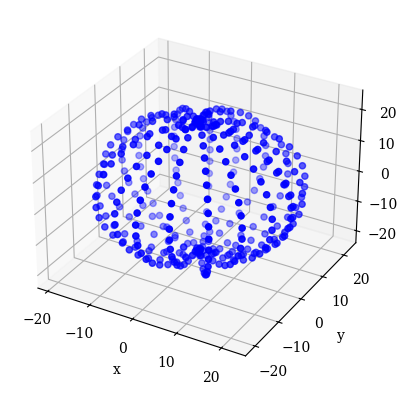

In [207]:
import numpy as np
import math

from matplotlib import rcParams
rcParams['font.family'] = 'serif'

#   3D plot of the
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def create_3D_points_ellipse(a = 21, b = 21.0, c =21, hasNoise = False):
  '''
  Creates a set of points that model an ellipse.
  a, b and c are the parameters

  return a tuple (data_x, data_y, data_z)

  Implements the parametric equation:
  x=a cosu sin v
  y=b sinu sin v
  z=c cosv
  u∈[0,2π]
  v∈[0,π]
  '''

  u = np.linspace(0., np.pi*2., 20)
  v = np.linspace(0., np.pi, 20)
  u, v = np.meshgrid(u,v)

  x = a*np.cos(u)*np.sin(v)
  y = b*np.sin(u)*np.sin(v)
  z = c*np.cos(v)

  if hasNoise:
    random_points = np.random.rand(len(x), 3) * 2
    x += random_points[:, 0]
    y += random_points[:, 1]
    z += random_points[:, 2]

  # turn this data into 1d arrays
  data_x = x.flatten()
  data_y = y.flatten()
  data_z = z.flatten()

  return data_x, data_y, data_z

# Generate the dataset
data_x, data_y, data_z = create_3D_points_ellipse(hasNoise = True)

#   3D plot of ellipsoid
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data_x, data_y, data_z, zdir='z', s=20, c='b', rasterized=True)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()

# Sphere Fitting Using Least Squares in 3D Point Clouds

This notebook describes how to use the **least squares method** to fit a sphere to a given set of 3D points. This technique is often useful in 3D data processing, computer vision, and object reconstruction, where a compact geometric representation is needed.

---

## Problem Formulation

Given a 3D point cloud with $N$ points, represented by their coordinates $(x_i, y_i, z_i)$, the goal is to find the **center** $(x_c, y_c, z_c)$ and the **radius** $r$ of a sphere that best fits these points.

### Sphere Equation

The general equation for a sphere in 3D space is:

$
\
(x - x_c)^2 + (y - y_c)^2 + (z - z_c)^2 = r^2
\
$

Expanding this equation, we get:

$
x^2 + y^2 + z^2 - 2x \cdot x_c - 2y \cdot y_c - 2z \cdot z_c + (x_c^2 + y_c^2 + z_c^2 - r^2) = 0
$

Let’s rewrite this in a form that makes it easier to solve with the least squares method:

$
x^2 + y^2 + z^2 = 2x \cdot x_c + 2y \cdot y_c + 2z \cdot z_c + (r^2 - (x_c^2 + y_c^2 + z_c^2))
$

If we define:

- $ d = r^2 - (x_c^2 + y_c^2 + z_c^2) $
- A vector of parameters we want to find, $ \mathbf{\beta} = [x_c, y_c, z_c, d] $

Then, our equation becomes linear in terms of $\mathbf{\beta}$:

$
x^2 + y^2 + z^2 = 2x \cdot x_c + 2y \cdot y_c + 2z \cdot z_c + d
$

---

## Setting Up the Least Squares Problem

For each point $(x_i, y_i, z_i)$ in the point cloud, we can now construct a linear equation:

$
x_i^2 + y_i^2 + z_i^2 = 2x_i \cdot x_c + 2y_i \cdot y_c + 2z_i \cdot z_c + d
$

This can be rewritten in matrix form as $ A \cdot \mathbf{\beta} = b $:

$
A = 2\begin{bmatrix} x_1 & y_1 & z_1 & 1 \\ x_2 & y_2 & z_2 & 1 \\ \vdots & \vdots & \vdots & \vdots \\ x_N & y_N & z_N & 1 \end{bmatrix}, \quad b = \begin{bmatrix} x_1^2 + y_1^2 + z_1^2 \\ x_2^2 + y_2^2 + z_2^2 \\ \vdots \\ x_N^2 + y_N^2 + z_N^2 \end{bmatrix}
$

The solution $\mathbf{\beta}$ to this least squares problem is given by:

$
\mathbf{\beta} = (A^T A)^{-1} A^T b
$

After solving for $\mathbf{\beta}$, we can extract the **center** $(x_c, y_c, z_c)$ as half of the first three elements of $\mathbf{\beta}$ and calculate the radius $r$ as:

$
r = \sqrt{x_c^2 + y_c^2 + z_c^2 + d}
$

## Summary

This notebook shows how to apply least squares fitting to find the center and radius of a sphere from a 3D point cloud. The sphere fitting process involves:
1. Formulating the least squares system.
2. Solving for parameters.
3. Using the parameters to estimate the sphere's radius and center.

This approach can be extended to other geometric primitives, making it highly versatile for 3D data analysis and reconstruction tasks.

In [208]:
def sphereFit(spX, spY, spZ):
    # Convert inputs to numpy arrays in case they are not already
    spX = np.array(spX)
    spY = np.array(spY)
    spZ = np.array(spZ)

    # Number of points
    num_points = len(spX)

    # Assemble the A matrix and b vector for the least squares problem
    A = np.c_[2*spX, 2*spY, 2*spZ, np.ones(num_points)]
    b = spX**2 + spY**2 + spZ**2

    # Solve the normal equation A^T A * beta = A^T * b using least squares
    beta, _, _, _ = np.linalg.lstsq(A, b, rcond=None)

    # Extract sphere parameters from beta
    C = beta[:3]
    radius = np.sqrt(np.sum(C**2) + beta[3])

    # Return the radius and the center coordinates
    return radius, C[0], C[1], C[2]

Radius: 21.104566318652054
Center: (1.0284890216533988, 1.1968933016459147, 1.1497749643881043)


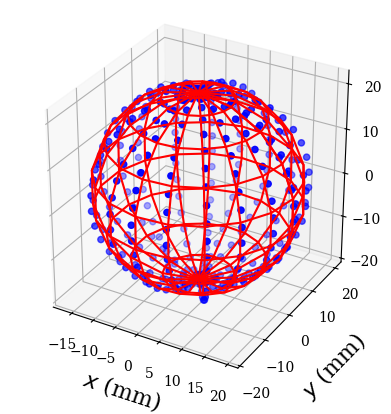

In [209]:
# Primitive extraction
r, x0, y0, z0 = sphereFit(data_x,data_y,data_z)

# Extract many points using the sphere model
u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
x=np.cos(u)*np.sin(v)*r
y=np.sin(u)*np.sin(v)*r
z=np.cos(v)*r
x = x + x0
y = y + y0
z = z + z0

# Print Extracted Parameters
print(f"Radius: {r}")
print(f"Center: ({x0}, {y0}, {z0})")

#   3D plot of Sphere
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data_x, data_y, data_z, zdir='z', s=20, c='b',rasterized=True)
ax.plot_wireframe(x, y, z, color="r")
ax.set_aspect('equal')
ax.set_xlim3d(data_x.min(), data_x.max())
ax.set_ylim3d(data_y.min(),data_y.max())
ax.set_zlim3d(data_z.min(), data_z.max())
ax.set_xlabel('$x$ (mm)',fontsize=16)
ax.set_ylabel('\n$y$ (mm)',fontsize=16)
zlabel = ax.set_zlabel('\n$z$ (mm)',fontsize=16)
plt.show()

# Sphere Fitting Using RANSAC in 3D Point Clouds

This notebook describes how to use the **RANSAC algorithm** to fit a sphere to a given set of 3D points. RANSAC is robust against outliers and is widely used in computer vision and 3D data analysis.

---

## Problem Formulation

Given a set of 3D points $(x_i, y_i, z_i)$, the goal is to find the **center** $(x_c, y_c, z_c)$ and **radius** $r$ of a sphere that best fits these points. The sphere is defined by the equation:

$
(x - x_c)^2 + (y - y_c)^2 + (z - z_c)^2 = r^2
$

### Sphere Equation Reformulation

The equation can be rewritten as:

$
x^2 + y^2 + z^2 = 2x_c x + 2y_c y + 2z_c z + (r^2 - (x_c^2 + y_c^2 + z_c^2))
$

Defining:

- $ d = r^2 - (x_c^2 + y_c^2 + z_c^2) $
- $ \beta = [x_c, y_c, z_c, d] $

We reformulate the fitting problem into a linear least squares problem.

---

## RANSAC Algorithm Overview

1. **Random Sampling**: Randomly select a subset of points (in this case, we need at least 4 points to define a sphere).
2. **Model Fitting**: Fit a sphere to the selected points using the least squares method.
3. **Inlier Detection**: For each point in the dataset, check if it is an inlier by computing its distance to the fitted sphere and comparing it to a threshold.
4. **Iteration**: Repeat the process for a specified number of iterations and keep track of the model with the most inliers.
5. **Final Model**: The best model is chosen based on the maximum number of inliers found.

---

## Summary

This notebook illustrates how to apply the RANSAC algorithm for robust sphere fitting in a 3D point cloud. The RANSAC method is beneficial in handling outliers and finding the best-fitting model by considering inliers. The steps include:
1. Random sampling of points.
2. Fitting the sphere using least squares.
3. Evaluating and keeping the best model based on inliers.

This approach can be adapted for other geometric primitives and is valuable in various applications in computer vision and 3D reconstruction.

---

### References
- RANSAC Algorithm: [RANSAC: Random Sample Consensus](https://en.wikipedia.org/wiki/Random_sample_consensus)
- Least Squares Fitting: [Least Squares](https://en.wikipedia.org/wiki/Least_squares)

-----------------------

In [210]:
def sphere_fit(points):
    """
    Fit a sphere to the given 3D points using the least squares method.
    Returns the center and radius of the sphere.
    """
    spX, spY, spZ = points[:, 0], points[:, 1], points[:, 2]

    # Formulate the A matrix
    A = np.c_[2*spX, 2*spY, 2*spZ, np.ones(len(spX))]
    b = spX**2 + spY**2 + spZ**2

    # Solve the least squares problem
    beta, _, _, _ = np.linalg.lstsq(A, b, rcond=None)

    # Calculate the center and radius
    center = beta[:3]
    radius = np.sqrt(np.sum(center**2) + beta[3])

    return center, radius

def sphereFit_RANSAC(spX, spY, spZ, iterations=100, threshold=0.1):
    """
    Fit a sphere to X, Y, and Z data points using RANSAC.
    Returns the radius and center points of the best fit sphere.
    """
    # Stack the X, Y, Z coordinates into a single array of shape (n_points, 3)
    points = np.vstack((spX, spY, spZ)).T

    best_radius = 0
    best_center = None
    max_inliers = 0

    for _ in range(iterations):
        # Randomly select 4 unique points
        sample_indices = np.random.choice(len(points), 4, replace=False)
        sample_points = points[sample_indices]

        # Fit a sphere to the sampled points
        center, radius = sphere_fit(sample_points)

        # Calculate the distances of all points to the fitted sphere
        distances = np.linalg.norm(points - center, axis=1) - radius

        # Count inliers: points that are within the threshold distance
        inliers = np.sum(np.abs(distances) < threshold)

        # Update the best sphere if this one has more inliers
        if inliers > max_inliers:
            max_inliers = inliers
            best_center = center
            best_radius = radius

    return best_radius, best_center[0], best_center[1], best_center[2]

Radius: 20.80912418496277
Center: (1.091276507726775, 1.1802003963283632, 1.6684742973767976)


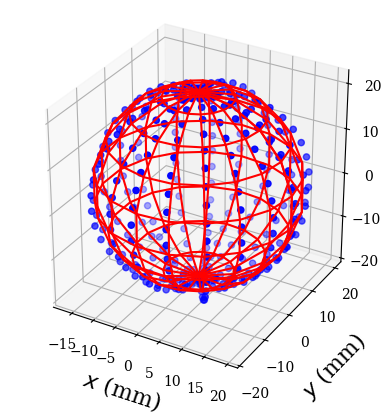

In [212]:
# Primitive extraction
r, x0, y0, z0 = sphereFit_RANSAC(data_x,data_y,data_z)

# Extract many points using the sphere model
u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
x=np.cos(u)*np.sin(v)*r
y=np.sin(u)*np.sin(v)*r
z=np.cos(v)*r
x = x + x0
y = y + y0
z = z + z0

# Print Extracted Parameters
print(f"Radius: {r}")
print(f"Center: ({x0}, {y0}, {z0})")

#   3D plot of Sphere
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data_x, data_y, data_z, zdir='z', s=20, c='b',rasterized=True)
ax.plot_wireframe(x, y, z, color="r")
ax.set_aspect('equal')
ax.set_xlim3d(data_x.min(), data_x.max())
ax.set_ylim3d(data_y.min(),data_y.max())
ax.set_zlim3d(data_z.min(), data_z.max())
ax.set_xlabel('$x$ (mm)',fontsize=16)
ax.set_ylabel('\n$y$ (mm)',fontsize=16)
zlabel = ax.set_zlabel('\n$z$ (mm)',fontsize=16)
plt.show()

-------------------

In [72]:
# Load a PLY file as a point cloud
pt_cloud_durius = o3d.io.read_point_cloud("durius.ply")
if pt_cloud_durius.is_empty():
  exit()

#...
#...
#...

# Visualize the clustered point cloud
pt_cloud_durius.paint_uniform_color([0.0, 1.0, 0])
o3d.visualization.draw_geometries([pt_cloud_durius, mesh_geometry])

NameError: name 'mesh_geometry' is not defined